In [1]:
import pandas as pd


proteome = pd.read_csv("../data/human_proteome.gz")
proteome["trivname"] = proteome["trivname"].apply(lambda x: x.split("_")[0])
data = pd.read_csv("../data/enzymes/processed.csv")
design = pd.read_csv("../data/enzymes/design.csv")
data.head(3)

,Protein Accession,Peptide,cht1,cht2,cht3,cht4,cht5,cht6,cht7,cht8,...,trp1,trp2,trp3,trp4,trp5,trp6,trp7,trp8,trp9,trp10
0,AHNK,SKGHYEVTGSDDETGKLQGSGVSLASK,0,0,0,0,0,0,0,0,...,0,1,1,1,1,0,1,1,1,1
1,AHNK,HELTEISNVDVETQSGK,0,0,0,0,0,0,0,0,...,1,1,1,1,1,1,1,1,1,1
2,AHNK,IKGDVPSVGLEGPDVDLQGPEAK,0,0,0,0,0,0,0,0,...,1,1,1,1,1,1,1,1,1,1


In [2]:
proteins = pd.read_csv("../data/enzymes/proteins.csv")

def shorten_histones(val : str):
    if val.startswith("H2"):
        return val[0:3]
    if val.startswith("H3"):
        return "H3"
    if val.startswith("CALM"):
        return "CALM"
    else:
        return val
    
proteins["Accession"] = proteins["Accession"].apply(lambda x: x.split("|")[1].split("_")[0])
proteins["short"] = proteins["Accession"].apply(lambda x: shorten_histones(x))
proteins.drop_duplicates("short", inplace=True)
proteins = proteins[proteins["#Peptides"] > 50]

proteins["pep per mass"] = proteins["#Peptides"] / proteins["Avg. Mass"] 
proteins = proteins.sort_values("pep per mass", ascending=False)["Accession"][0:20]
proteins

4      H2B1M
33     H2A1J
64        H4
113     CH10
7       ACTB
1       CH60
182      H32
22     ANXA2
134     RL40
69       H15
15      ATPB
16     ANXA1
25       G3P
83     CALM2
504    S10A6
42      ACTC
43      ACTA
8       ROA2
133    RS27A
72       H14
Name: Accession, dtype: object

In [3]:
import numpy as np


data = data[data["Protein Accession"].isin(proteins)]
samples = design["sample"]
data_dict = {}  # sample: {protein: {peptide:amount}}

for sample in samples:
    protein_dict = {}
    for protein in data["Protein Accession"].unique():
        sample_data = (
            data[["Protein Accession", "Peptide", sample]]
            .replace(0, np.nan)
            .dropna(subset=[sample])
        )
        sample_data = sample_data[sample_data["Protein Accession"] == protein]
        peptide_dict = {}
        # insert the original protein sequence
        try:
            protein_sequence = proteome[proteome["trivname"].isin([f"{protein}_HUMAN", protein])][
                "seq"
            ].values[0]
        except:
            print(protein)
            continue
        peptide_dict[protein_sequence] = (
            1  # probably want to replace this with some reasonable number
        )
        for i, row in sample_data.iterrows():
            peptide = row["Peptide"]
            abundance = row[sample]
            peptide_dict[peptide] = abundance
        protein_dict[protein] = peptide_dict
    data_dict[sample] = protein_dict
data_dict

{'cht1': {'CH60': {'MLRLPTVFRQMRPVSRVLAPHLTRAYAKDVKFGADARALMLQGVDLLADAVAVTMGPKGRTVIIEQSWGSPKVTKDGVTVAKSIDLKDKYKNIGAKLVQDVANNTNEEAGDGTTTATVLARSIAKEGFEKISKGANPVEIRRGVMLAVDAVIAELKKQSKPVTTPEEIAQVATISANGDKEIGNIISDAMKKVGRKGVITVKDGKTLNDELEIIEGMKFDRGYISPYFINTSKGQKCEFQDAYVLLSEKKISSIQSIVPALEIANAHRKPLVIIAEDVDGEALSTLVLNRLKVGLQVVAVKAPGFGDNRKNQLKDMAIATGGAVFGEEGLTLNLEDVQPHDLGKVGEVIVTKDDAMLLKGKGDKAQIEKRIQEIIEQLDVTTSEYEKEKLNERLAKLSDGVAVLKVGGTSDVEVNEKKDRVTDALNATRAAVEEGIVLGGGCALLRCIPALDSLTPANEDQKIGIEIIKRTLKIPAMTIAKNAGVEGSLIVEKIMQSSSEVGYDAMAGDFVNMVEKGIIDPTKVVRTALLDAAGVASLLTTAEVVVTEIPKEEKDPGMGAMGGMGGGMGGGMF': 1,
   'SEKKISSIQSIVPALEIANAH': 1.0,
   'VLLSEKKISSIQSIVPALEIANAH': 1.0,
   'KVGGTSDVEVNEKKDRVTDAL': 2.0,
   'SLTPANEDQKIGIEIIKRTL': 2.0,
   'DLGKVGEVIVTKDDAMLL': 1.0,
   'KDGVTVAKSIDLKDKY': 1.0,
   'VTKDGVTVAKSIDLKDKY': 1.0,
   'LSEKKISSIQSIVPALEIANAH': 1.0,
   'DLGKVGEVIVTKDDAML': 1.0,
   'KKQSKPVTTPEEIAQVA': 2.0,
   'KVGGTSDVEVNEKKDRVTD': 1.0,
   'VQDVANNTNEEAGDGTTTATVL': 2.0,
   'VIIAEDVDGEALSTL': 

/Users/erikhartman/dev/disassembly/.venv/lib/python3.9/site-packages/seaborn/matrix.py:530: ClusterWarning: scipy.cluster: The symmetric non-negative hollow observation matrix looks suspiciously like an uncondensed distance matrix
  linkage = hierarchy.linkage(self.array, method=self.method,
/Users/erikhartman/dev/disassembly/.venv/lib/python3.9/site-packages/seaborn/matrix.py:530: ClusterWarning: scipy.cluster: The symmetric non-negative hollow observation matrix looks suspiciously like an uncondensed distance matrix
  linkage = hierarchy.linkage(self.array, method=self.method,


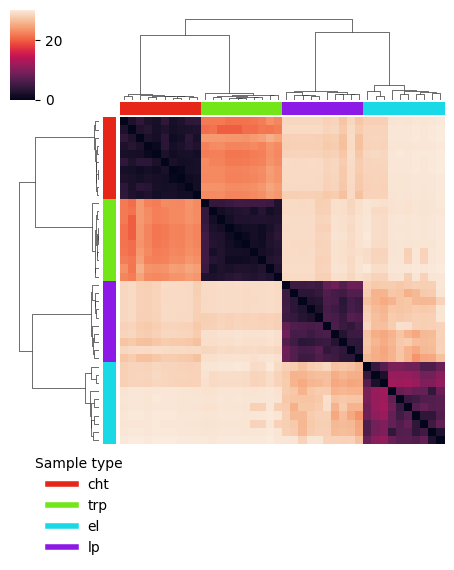

In [4]:
from disassembly.util import KL
from disassembly.estimate_parameters import compare

# data_dict  sample:protein:peptides

protein = "H4"

comparisons = {}
for i in data_dict.keys():
    if protein in data_dict[i].keys():
        peptidome_comp_1 = data_dict[i][protein]
        comparisons[i] = {}
        for j in data_dict.keys():
            if protein in data_dict[j].keys():
                peptidome_comp_2 = data_dict[j][protein]
                p, q = compare(peptidome_comp_1, peptidome_comp_2)
                err = KL(p, q) + KL(q, p)
                comparisons[i][j] = err

import pandas as pd

comps_df = pd.DataFrame(comparisons)

import seaborn as sns
from matplotlib.lines import Line2D

labels = design["group"]
lut = dict(zip(set(labels), sns.hls_palette(len(set(labels)), l=0.5, s=0.8)))
row_colors = design["group"].map(lut)

g = sns.clustermap(
    comps_df,
    figsize=(5, 5),
    row_colors=row_colors.to_numpy(),
    col_colors=row_colors.to_numpy(),
)
g.ax_heatmap.set_xticks([])
g.ax_heatmap.set_yticks([])
legend_elements = [
    Line2D([0], [0], color=c, lw=4, label=l) for l, c in zip(lut.keys(), lut.values())
]
g.ax_heatmap.legend(
    frameon=False,
    handles=legend_elements,
    loc="upper left",
    bbox_to_anchor=(-0.3, 0),
    title="Sample type",
)

In [5]:
from disassembly.estimate_weights_gd import WeightEstimatorGD
from disassembly.disassembly import get_disassembly_indexes_mc, get_disassembly

results = {}  # dict of sample: protein_disassembly
wegd = WeightEstimatorGD(lr=.1, n_iterations=250)
n_pep = {}
average_di = {}
spc = {}

for sample, protein_dict in data_dict.items():
    print(f"\n ---{sample}--- \n")
    protein_disassembly = {}  # dict of protein: disassembly
    protein_n_pep = {}
    protein_di = {}
    protein_spc = {}
    for protein, peptidome in protein_dict.items():
        graph = wegd.run(peptidome, verbose=True)
        di = get_disassembly_indexes_mc(graph, N_particles=10000)
        disassembly = get_disassembly(peptidome, di, exp=True)
        protein_disassembly[protein] = disassembly
        protein_n_pep[protein] = len(peptidome.values())
        protein_di[protein] = np.mean(list(di.values()))
        protein_spc[protein] = sum(peptidome.values())
    results[sample] = protein_disassembly
    n_pep[sample] = protein_n_pep
    average_di[sample] = protein_di
    spc[sample] = protein_spc


 ---cht1--- 

 249 / 250 | 0.03, kl: 0.03, reg: 0.00  | nz: 96 | 
 Averaged DI: 1.60
 249 / 250 | 0.04, kl: 0.04, reg: 0.00  | nz: 190 | 
 Averaged DI: 2.09
 249 / 250 | 1.11, kl: 1.11, reg: 0.00  | nz: 122 | 
 Averaged DI: 1.87
 249 / 250 | 0.01, kl: 0.01, reg: 0.00  | nz: 44 | 
 Averaged DI: 1.38
 249 / 250 | 0.04, kl: 0.04, reg: 0.00  | nz: 64 | 
 Averaged DI: 1.41
 249 / 250 | 0.02, kl: 0.02, reg: 0.00  | nz: 37 | 
 Averaged DI: 1.33
 249 / 250 | 0.01, kl: 0.01, reg: 0.00  | nz: 47 | 
 Averaged DI: 1.43
 143 / 250 | 0.01, kl: 0.01, reg: 0.00  | nz: 51 | 
 Averaged DI: 1.57
 249 / 250 | 0.04, kl: 0.04, reg: 0.00  | nz: 120 | 
 Averaged DI: 1.98
 249 / 250 | 0.03, kl: 0.03, reg: 0.00  | nz: 92 | 
 Averaged DI: 1.89
 249 / 250 | 0.03, kl: 0.03, reg: 0.00  | nz: 92 | 
 Averaged DI: 1.75
 149 / 250 | 0.01, kl: 0.01, reg: 0.00  | nz: 66 | 
 Averaged DI: 1.77
 81 / 250 | 0.01, kl: 0.01, reg: 0.00  | nz: 32 | 
 Averaged DI: 1.60
 95 / 250 | 0.01, kl: 0.01, reg: 0.00  | nz: 21 | 
 Averaged

In [6]:
n_pep_df = pd.DataFrame(n_pep).stack().reset_index().rename(columns={"level_0":"protein", "level_1":"sample", 0:"n_pep"})
results_df = pd.DataFrame(results).stack().reset_index().rename(columns={"level_0":"protein", "level_1":"sample", 0:"d"})
average_di_df = pd.DataFrame(average_di).stack().reset_index().rename(columns={"level_0":"protein", "level_1":"sample", 0:"di"})
average_di_df.head(3)

,protein,sample,di
0,CH60,cht1,1.598689
1,CH60,cht2,1.603468
2,CH60,cht3,1.703412


In [7]:
n_pep_df = pd.DataFrame(n_pep).stack().reset_index().rename(columns={"level_0":"protein", "level_1":"sample", 0:"npep"})
results_df = pd.DataFrame(results).stack().reset_index().rename(columns={"level_0":"protein", "level_1":"sample", 0:"d"})
results_df = results_df.merge(n_pep_df).merge(design).merge(average_di_df)
results_df["d/npep"] = results_df["d"] / results_df["npep"]

<Axes: xlabel='npep', ylabel='d'>

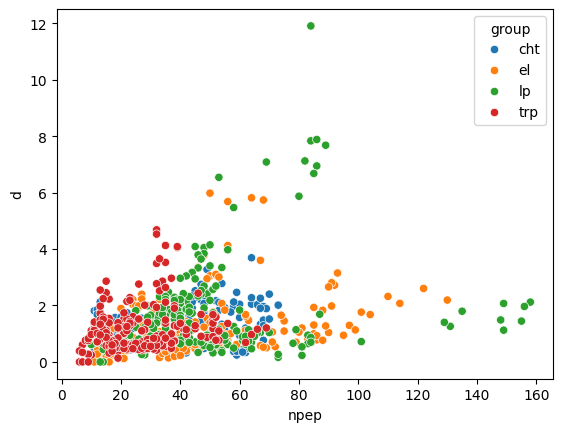

In [8]:
sns.scatterplot(results_df, x="npep", y="d", hue="group")

/Users/erikhartman/dev/disassembly/.venv/lib/python3.9/site-packages/seaborn/categorical.py:3398: UserWarning: 17.5% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
/Users/erikhartman/dev/disassembly/.venv/lib/python3.9/site-packages/seaborn/categorical.py:3398: UserWarning: 12.5% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
/Users/erikhartman/dev/disassembly/.venv/lib/python3.9/site-packages/seaborn/categorical.py:3398: UserWarning: 32.5% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
/Users/erikhartman/dev/disassembly/.venv/lib/python3.9/site-packages/seaborn/categorical.py:3398: UserWarning: 40.0% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)


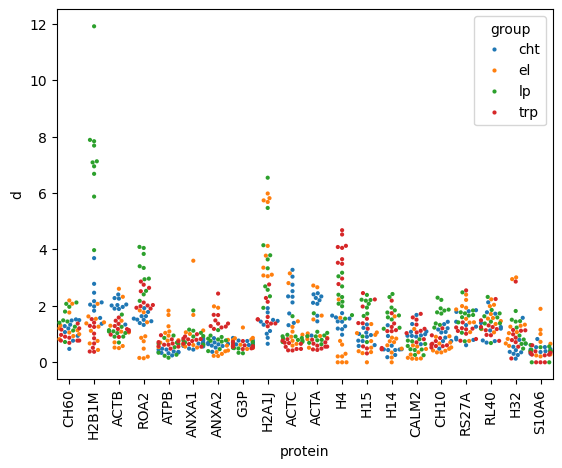

In [9]:
import matplotlib.pyplot as plt
sns.swarmplot(
    results_df, x="protein", y="d", hue="group", s= 3
)
plt.xticks(rotation=90)
plt.show()

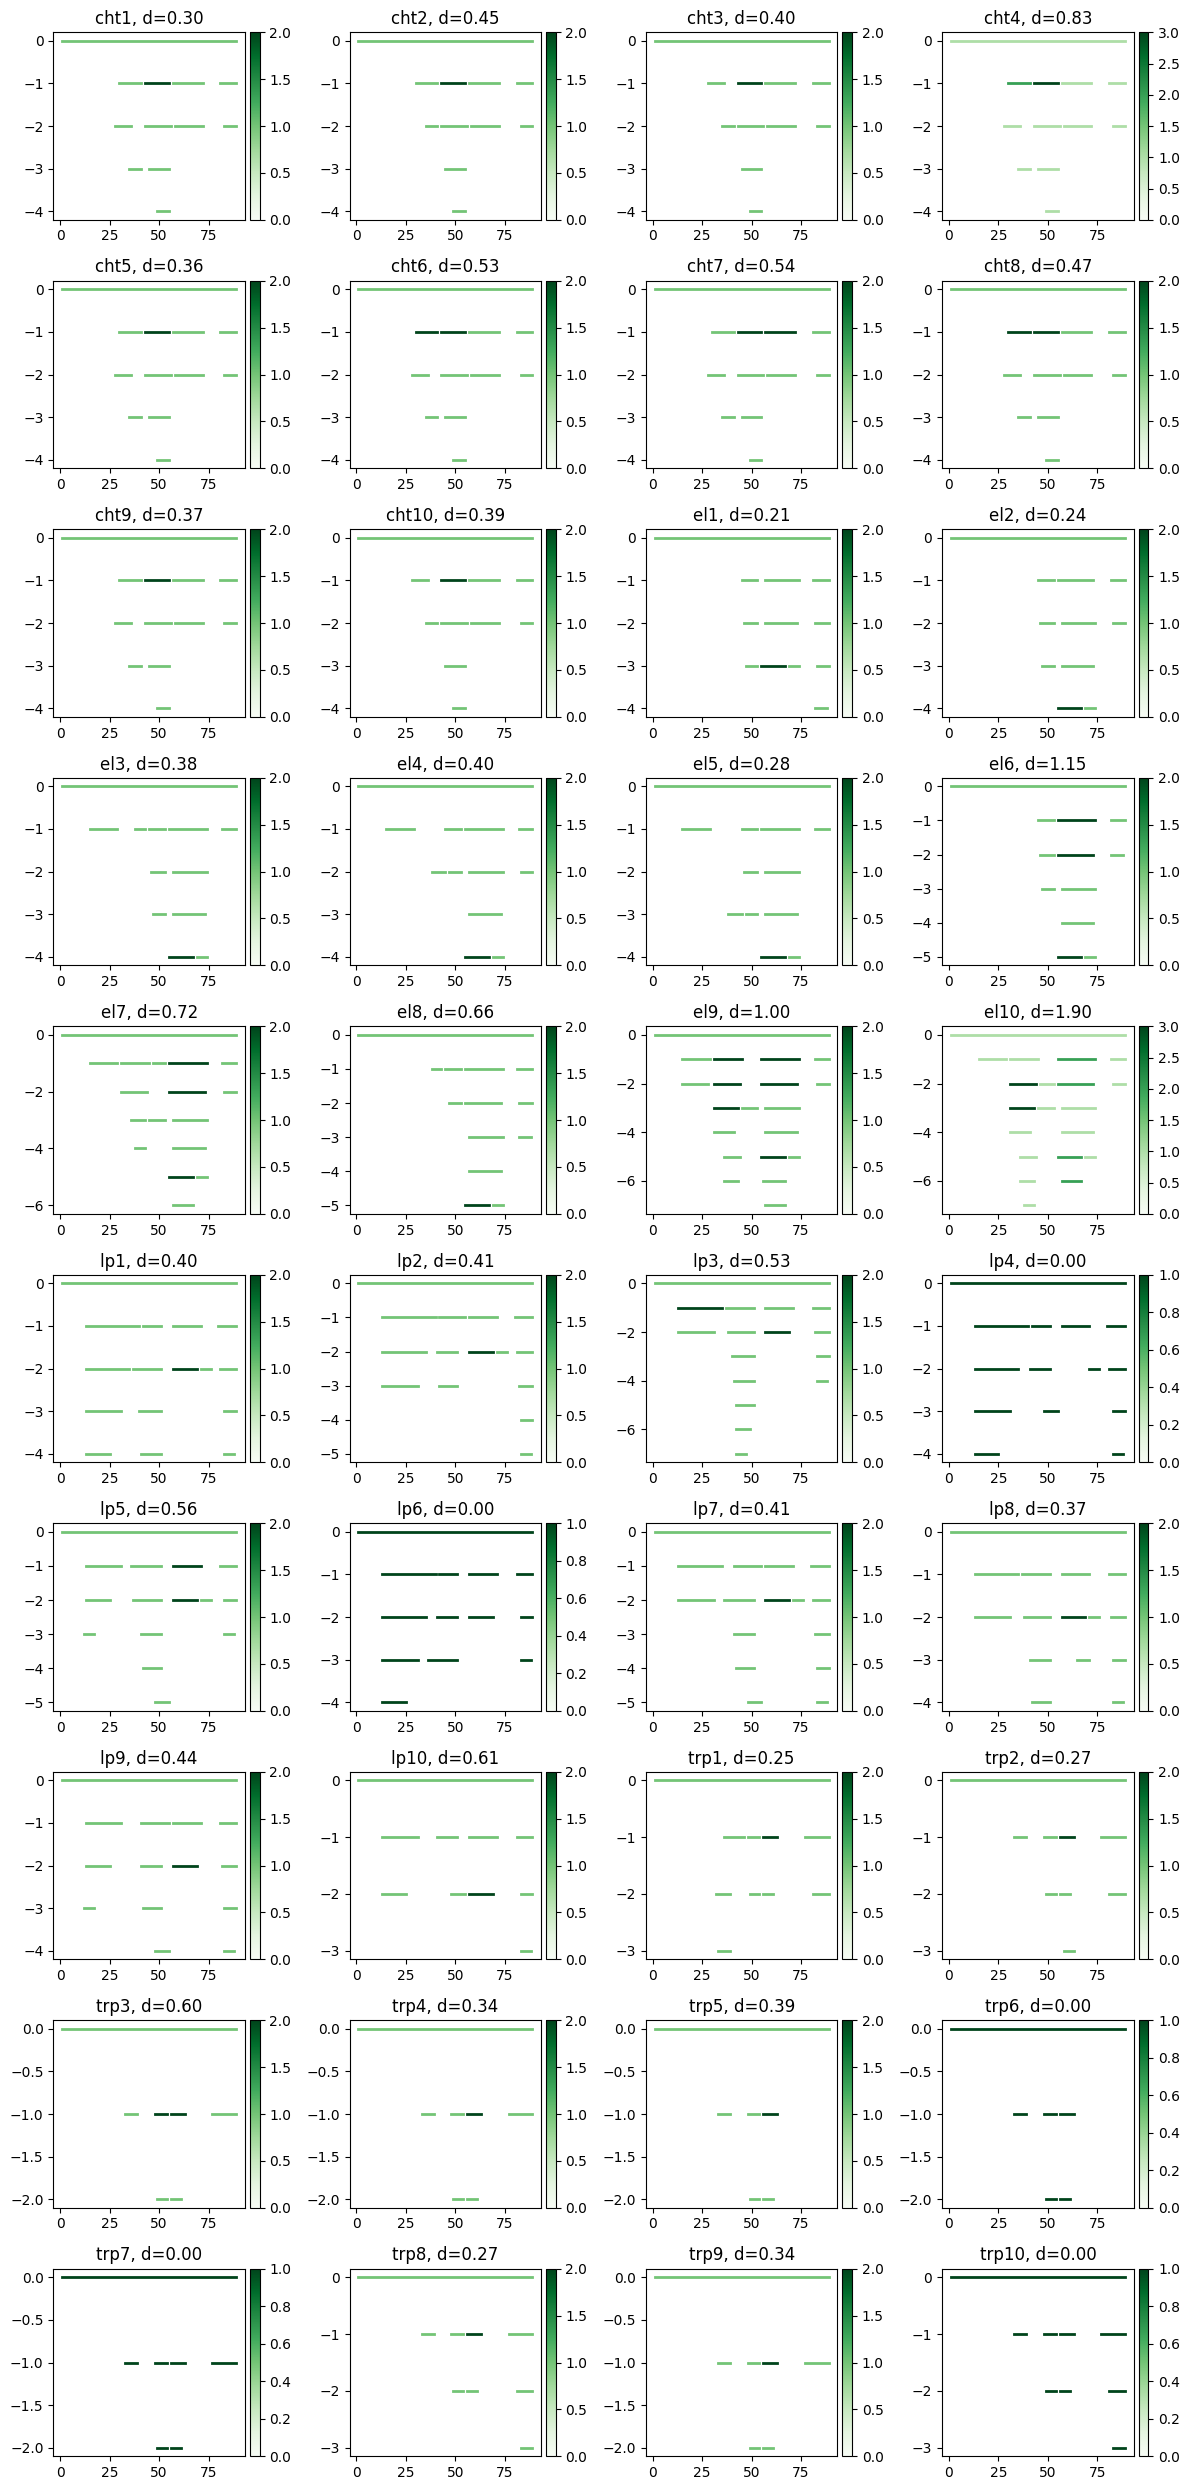

In [10]:
from disassembly.util import plot_peptidome
import matplotlib.pyplot as plt

fig, axs = plt.subplots(
    10,
    4,
    figsize=(12, 25),
)
for i, ax in zip(range(len(samples)), axs.ravel()):

    ax.set_title(f"{samples[i]}, d={results[samples[i]][protein]:.2f}")

    plot_peptidome(
        proteome[proteome["trivname"] == protein]["seq"].values[0],
        data_dict[samples[i]][protein],
        ax,
    )
plt.tight_layout()

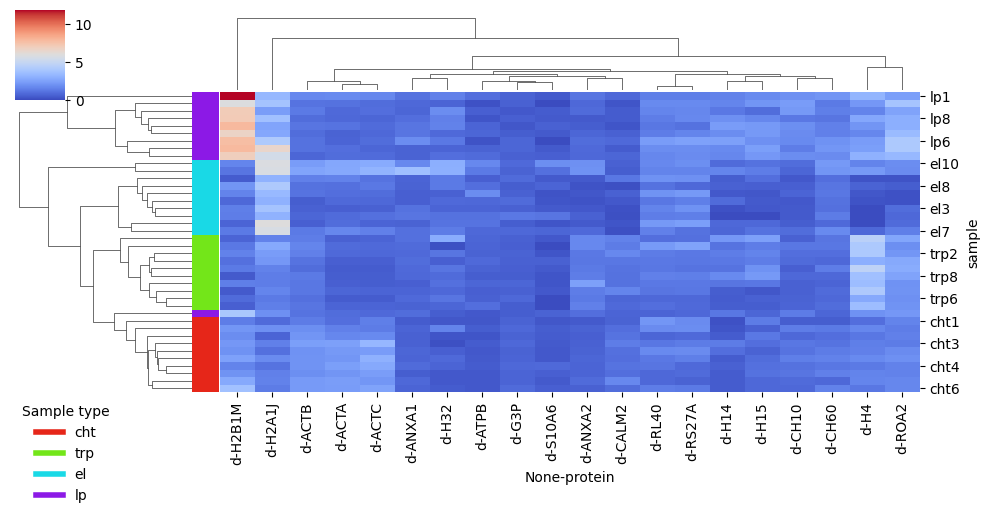

In [11]:
import seaborn as sns
import numpy as np

heatmap_df = results_df[["sample", "d", "protein"]]
heatmap_df = heatmap_df.pivot(columns="protein", index="sample")

g = sns.clustermap(
    heatmap_df,
    cmap="coolwarm",
    figsize=(10, 5),
    row_colors=row_colors.to_numpy(),

)

g.ax_heatmap.legend(
    frameon=False,
    handles=legend_elements,
    loc="upper left",
    bbox_to_anchor=(-0.3, 0),
    title="Sample type",
)

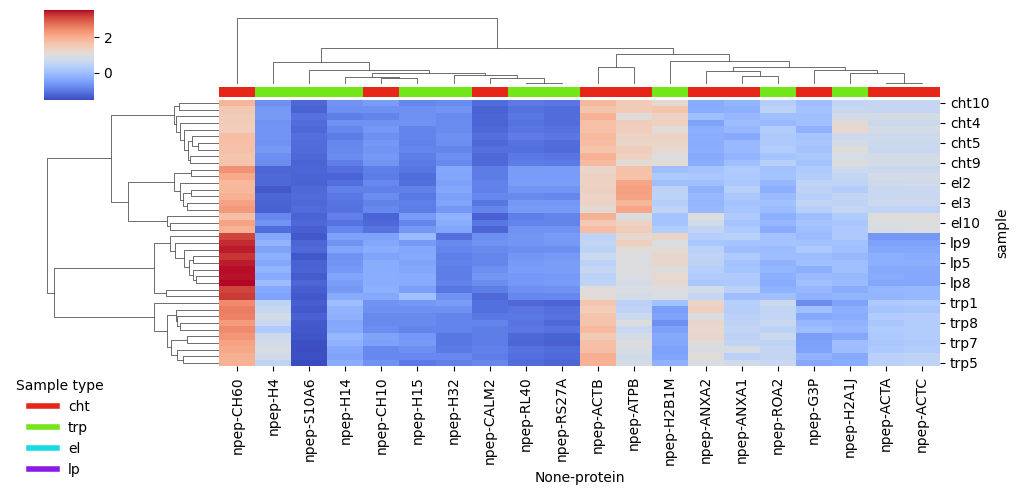

In [12]:

heatmap_df = results_df[["sample", "npep", "protein"]]
heatmap_df = heatmap_df.pivot(columns="protein", index="sample")

g = sns.clustermap(
    heatmap_df,
    cmap="coolwarm",
    figsize=(10, 5),
    col_colors=row_colors.to_numpy(),
    z_score=False,
)

g.ax_heatmap.legend(
    frameon=False,
    handles=legend_elements,
    loc="upper left",
    bbox_to_anchor=(-0.3, 0),
    title="Sample type",
)

/Users/erikhartman/dev/disassembly/.venv/lib/python3.9/site-packages/seaborn/categorical.py:3398: UserWarning: 22.5% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
/Users/erikhartman/dev/disassembly/.venv/lib/python3.9/site-packages/seaborn/categorical.py:3398: UserWarning: 15.0% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
/Users/erikhartman/dev/disassembly/.venv/lib/python3.9/site-packages/seaborn/categorical.py:3398: UserWarning: 12.5% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
/Users/erikhartman/dev/disassembly/.venv/lib/python3.9/site-packages/seaborn/categorical.py:3398: UserWarning: 10.0% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)


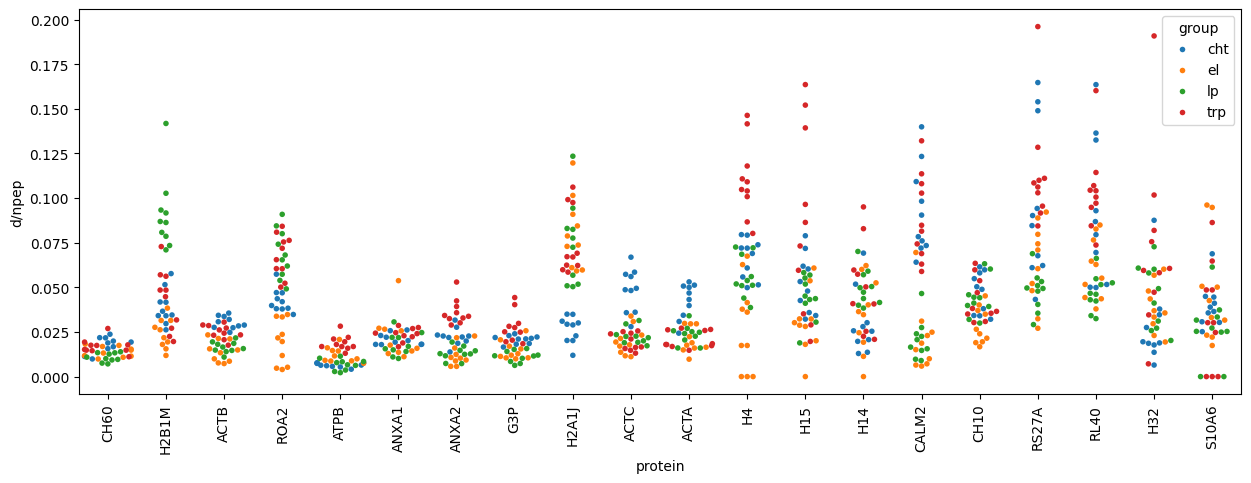

In [13]:

plt.figure(figsize=(15,5))
sns.swarmplot(
    results_df, x="protein", y="d/npep", hue="group", s=4
)
plt.xticks(rotation=90)
plt.show()

<Axes: xlabel='Density', ylabel='d/npep'>

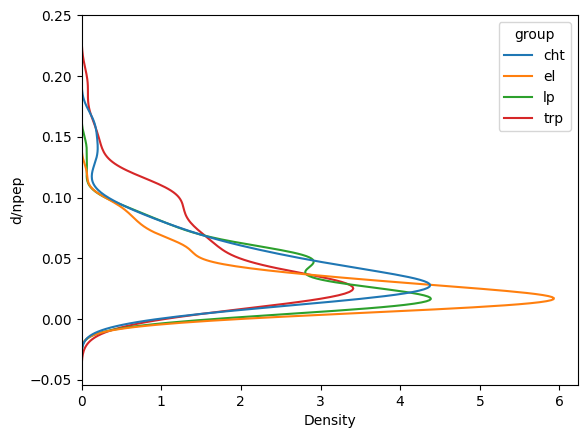

In [14]:
sns.kdeplot(results_df, y="d/npep", hue="group")

# Compare simulation with real




In [21]:
import pandas as pd

# Read data
proteome = pd.read_csv("../data/human_proteome.gz")
proteome["trivname"] = proteome["trivname"].apply(lambda x: x.split("_")[0])
data = pd.read_csv("../data/enzymes/processed.csv")
design = pd.read_csv("../data/enzymes/design.csv")

# Select protein
protein = "H4"
protein_sequence = proteome[proteome["trivname"].isin([f"{protein}_HUMAN", protein])][
                "seq"
            ].values[0]

import numpy as np

# Prepare in vitro data
data = data[data["Protein Accession"] == protein]
samples = design["sample"]
data_dict = {}  # sample: {protein: {peptide:amount}}

for sample in samples:
    protein_dict = {}
    for protein in data["Protein Accession"].unique():
        sample_data = (
            data[["Protein Accession", "Peptide", sample]]
            .replace(0, np.nan)
            .dropna(subset=[sample])
        )
        peptide_dict = {}
        # insert the original protein sequence
        peptide_dict[protein_sequence] = (
            1  # probably want to replace this with some reasonable number
        )
        for i, row in sample_data.iterrows():
            peptide = row["Peptide"]
            abundance = row[sample]
            peptide_dict[peptide] = abundance
        protein_dict[protein] = peptide_dict
    data_dict[sample] = protein_dict


from disassembly.simulate_proteolysis import (
    simulate_proteolysis,
    enzyme_set,
    enzyme,
)
from disassembly.util import amino_acids

n_generate = 50


kr_enzymes = enzyme_set(
    [
        enzyme({"K": 0.5, "R": 0.5}, "trypsin"),
    ],
    [1],
    [1],
)

viat_enzymes = enzyme_set(
    [
        enzyme({"V": 0.5, "I": 0.25, "A": 0.15, "T": 0.1}, "elne"),
    ],
    [1],
    [1],
)

random_enzymes = enzyme_set(
    [enzyme({aa: 1 / len(amino_acids) for aa in amino_acids.values()}, "random")],
    [1],
    [1],
)

#simulate data
generated_peptidomes = {"name": [], "peptidome": []}

names = ["kr", "viat"]


for enz, name in zip(
    [kr_enzymes, viat_enzymes], names
):
    print(name)
    for i in range(10):
        print(f"\r{i}",  flush=True)
        generated_peptidome = simulate_proteolysis(
            protein_sequence,
            n_start=3,
            n_generate=n_generate,
            endo_or_exo_probability=[.9, .1],
            enzymes=enz,
            graph=False,
            verbose=False,
        )
        generated_peptidomes["name"].append(f"{name}_{i}")
        generated_peptidomes["peptidome"].append(generated_peptidome)

kr
0
1
2


/Users/erikhartman/dev/disassembly/src/disassembly/simulate_proteolysis.py:227: RuntimeWarning: invalid value encountered in scalar divide
  p / sum(index_to_cut.values()) for p in index_to_cut.values()


3
4
5
6
7
8
9
viat
0
1
2
3
4
5
6
7
8
9


In [22]:
# Predict disassembly for each
from disassembly.estimate_weights_gd import WeightEstimatorGD
from disassembly.disassembly import get_disassembly_indexes_mc, get_disassembly

disassembly_dict = {}

wegd = WeightEstimatorGD(lr=.1, n_iterations=250)

for sample, protein_dict in data_dict.items():
    print(f"\n ---{sample}--- \n")
    peptidome = data_dict[sample][protein]
    print(len(peptidome))
    
    graph = wegd.run(peptidome, verbose=True)
    di = get_disassembly_indexes_mc(graph, N_particles=10000)
    disassembly = get_disassembly(peptidome, di, exp=True)
    disassembly_dict[sample] = disassembly
    
for name, peptidome in zip(generated_peptidomes["name"], generated_peptidomes["peptidome"]):
    graph = wegd.run(peptidome, verbose=True)
    di = get_disassembly_indexes_mc(graph, N_particles=10000)
    disassembly = get_disassembly(peptidome, di, exp=True)

    disassembly_dict[name] = disassembly



 ---cht1--- 

19
 162 / 250 | 0.01, kl: 0.01, reg: 0.00  | nz: 66 | 
 Averaged DI: 1.71

 ---cht2--- 

21
 145 / 250 | 0.01, kl: 0.01, reg: 0.00  | nz: 73 | 
 Averaged DI: 1.79

 ---cht3--- 

20
 102 / 250 | 0.01, kl: 0.01, reg: 0.00  | nz: 72 | 
 Averaged DI: 1.72

 ---cht4--- 

21
 129 / 250 | 0.01, kl: 0.01, reg: 0.00  | nz: 69 | 
 Averaged DI: 1.96

 ---cht5--- 

21
 181 / 250 | 0.01, kl: 0.01, reg: 0.00  | nz: 74 | 
 Averaged DI: 1.90

 ---cht6--- 

24
 249 / 250 | 0.01, kl: 0.01, reg: 0.00  | nz: 92 | 
 Averaged DI: 2.01

 ---cht7--- 

21
 209 / 250 | 0.01, kl: 0.01, reg: 0.00  | nz: 75 | 
 Averaged DI: 1.91

 ---cht8--- 

23
 186 / 250 | 0.01, kl: 0.01, reg: 0.00  | nz: 86 | 
 Averaged DI: 1.91

 ---cht9--- 

22
 225 / 250 | 0.01, kl: 0.01, reg: 0.00  | nz: 77 | 
 Averaged DI: 1.93

 ---cht10--- 

20
 86 / 250 | 0.01, kl: 0.01, reg: 0.00  | nz: 67 | 
 Averaged DI: 1.76

 ---el1--- 

8
 17 / 250 | 0.01, kl: 0.01, reg: 0.00  | nz: 10 | 
 Averaged DI: 1.23

 ---el2--- 

12
 38 / 2

In [23]:
disassembly_dict

{'cht1': 0.8510995099902434,
 'cht2': 1.1686894199720816,
 'cht3': 1.423055292992848,
 'cht4': 1.2392243268614833,
 'cht5': 1.4833841350643708,
 'cht6': 1.3705270143397719,
 'cht7': 1.377491085257025,
 'cht8': 2.0840729379480645,
 'cht9': 1.8403314113774965,
 'cht10': 1.482310904617603,
 'el1': 0.3020313142732272,
 'el2': 0.20909860218915732,
 'el3': 0.0,
 'el4': 0.20909860218915735,
 'el5': 0.0,
 'el6': 0.0,
 'el7': 0.9109953413809428,
 'el8': 0.627295806567472,
 'el9': 2.2658346304978187,
 'el10': 1.6948458015574672,
 'lp1': 2.840166710042341,
 'lp2': 2.651524161940407,
 'lp3': 2.975690888104761,
 'lp4': 2.4235563837074467,
 'lp5': 2.0188488388132924,
 'lp6': 2.301823589281652,
 'lp7': 1.6051952380212726,
 'lp8': 2.5200200835604507,
 'lp9': 1.9810128629595234,
 'lp10': 1.7636107589670043,
 'trp1': 5.1081414686166635,
 'trp2': 3.855433963080836,
 'trp3': 3.0853994917554632,
 'trp4': 4.674746249523759,
 'trp5': 3.948398540394667,
 'trp6': 3.5793740265700205,
 'trp7': 3.315480981205892,

<Axes: xlabel='type', ylabel='disassembly'>

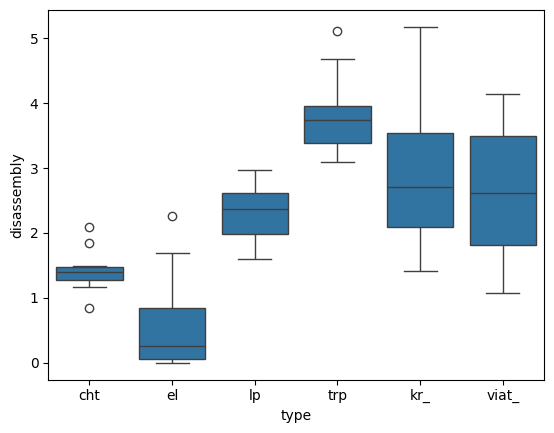

In [24]:
import re

pattern = "[0-9]"
disassembly_df = pd.DataFrame(disassembly_dict, index=["disassembly"]).T
disassembly_df["type"] = [re.sub(pattern,'', x) for x in disassembly_dict.keys()]

import seaborn as sns

sns.boxplot(disassembly_df, y="disassembly", x="type")